# Example GSE123139 co-expression

### Dataset
This is an demonstration of co-expression analysis with Normalisr within dysfunctional T cells in human melanoma scRNA-seq. This includes iterative removal of top GO pathways. Only a subset of cells were extracted from GSE123139 dataset for this demonstration. You can change it to all the cells by following the guideline in example README.

**Warning**: You will only get the actual results with the **full dataset** of all cells. This example is intended as a demonstration of use for Normalisr, than an exact reproduction of our results in the manuscript.

### Usage
You can get the help of any function by typing ?func in jupyter notebook. For example, the line below shows documentation for function 'open'.

`?open`

To get help for Normalisr, try a specific function such as

`import normalisr.normalisr as norm
?norm.coex`

In [1]:
import numpy as np
import normalisr.normalisr as norm
from os.path import join as pjoin
import matplotlib.pyplot as plt
from scipy.io import mmread
import networkx as nx
import pandas as pd

diri='../data/coex'

### Optional extra logging

In [ ]:
import logging
logging.basicConfig(level=logging.DEBUG)

### Load data

In [2]:
dt0=mmread(pjoin(diri,'0_read.mtx.gz')).astype(int).toarray()
dc=np.loadtxt(pjoin(diri,'0_cov.tsv.gz'),delimiter='\t',dtype=int)
with open(pjoin(diri,'0_gene.txt'),'r') as f:
	namet=np.array([x.strip() for x in f.readlines()])
with open(pjoin(diri,'0_cell.txt'),'r') as f:
	names=np.array([x.strip() for x in f.readlines()])
with open(pjoin(diri,'0_cov.txt'),'r') as f:
	namec=np.array([x.strip() for x in f.readlines()])
nc,ns,nt=[len(x) for x in [namec,names,namet]]
assert dt0.shape==(nt,ns) and dc.shape==(nc,ns)

### Initial QC for low read cell and gene removal

In [3]:
select=norm.qc_reads(dt0,0,500,0.02,500,100,0)
print('Genes passed QC: {}/{}'.format(len(select[0]),nt))
print('Cells passed QC: {}/{}'.format(len(select[1]),ns))

dt0=dt0[select[0]][:,select[1]].copy()
dc=dc[:,select[1]].copy()
namet=namet[select[0]]
names=names[select[1]]
ns,nt=[len(x) for x in [names,namet]]
assert dt0.shape==(nt,ns) and dc.shape==(nc,ns)

Genes passed QC: 1591/27892
Cells passed QC: 5084/5104


### Compute Bayesian logCPM and cellular summary covariates

In [4]:
dt,_,_,dc2=norm.lcpm(dt0)
dc=np.concatenate([dc,dc2],axis=0)

### Normalize covariates and add constant-1 covariate

In [5]:
dc=norm.normcov(dc)

### Compute variance normalization factors for each gene and each cell

In [6]:
sf=norm.scaling_factor(dt0)
weight=norm.compute_var(dt,dc)

### Detect very-low-variance cell outliers

In [7]:
select=norm.qc_outlier(weight)

### Remove very-low-variance cell outliers

In [8]:
print('Cells passed outlier QC: {}/{}'.format(select.sum(),ns))
dt0=dt0[:,select].copy()
dt=dt[:,select].copy()
dc=dc[:,select].copy()
weight=weight[select]
names=names[select]
ns=len(names)

Cells passed outlier QC: 5063/5084


### Normalize gene expression at mean and variance levels and covariates at variance level

In [9]:
dt,dc=norm.normvar(dt,dc,weight,sf)

### Compute co-expression network from 0 to 5 removals of top GO pathways

In [10]:
#Maximum number of iterations of GO pathway removal
lvmax=5
#Q-value cutoff when binarizing network
qcut=1E-8
#GO DAG file, downloadable from http://geneontology.org/docs/download-ontology/
go_file='../data/go/go-basic.obo'
#GO annotation file, downloadable from http://current.geneontology.org/products/pages/downloads.html
goa_file='../data/go/goa-human.gaf'
#Gene name conversion rule from your gene ID system to GO annotation file's ID system
#Format: (Your ID system, GO annotation file's ID system, species)
#Names of gene ID systems can be found at https://docs.mygene.info/en/latest/doc/data.html
conversion=("symbol,alias","uniprot.Swiss-Prot","human")

dc2=dc.copy()
coex=[]
for xi in range(lvmax+1):
	#Compute co-expression network of P-values and Pearson R
	coex1=norm.coex(dt,dc2)
	#Binarize co-expression network
	coex2=norm.binnet(coex1[0],qcut)
	#Get strongest GO pathway 
	go=norm.gotop(coex2,namet,go_file,goa_file,conversion=conversion)
	#Store this iteration of results
	coex.append((coex1,coex2,go,dc2))
	#Prepare GO covariate for next iteration
	dc2=norm.pccovt(dt,dc2,namet,go[3])


querying 1-1000...done.
querying 1001-1591...done.
Finished.
213 input query terms found dup hits:
	[('RPS18', 2), ('RPL7AP30', 2), ('SHFM1', 2), ('RPL5P17', 2), ('RNASEK-C17orf49', 2), ('RPL13AP25', 
135 input query terms found no hit:
	['RP4-753P9.3', 'MIR4461', 'AD000671.6', 'RP11-397E7.1', 'RP11-75L1.2', 'CTC-575D19.1', 'CTB-79E8.3'
Pass "returnall=True" to return complete lists of duplicate or missing query terms.
../data/go/go-basic.obo: fmt(1.2) rel(2020-05-02) 47,240 GO Terms
  READ      505,463 associations: ../data/go/goa-human.gaf
fisher module not installed.  Falling back on scipy.stats.fisher_exact


Propagating term counts to parents ..


 98%  1,290 of  1,313 population items found in association
 98%     61 of     62 study items found in association
Calculating 8,432 uncorrected p-values using fisher_scipy_stats
   8,432 GO terms are associated with  1,290 of  1,313 population items
   1,693 GO terms are associated with     61 of     62 study items
      13 GO terms found significant (< 0.05=alpha) after multitest correction: local bonferroni
      13 GO terms found significant (< 0.05=alpha) after multitest correction: local sidak
      13 GO terms found significant (< 0.05=alpha) after multitest correction: local holm
   8432 items WROTE: /tmp/tmp48nz9k3k
querying 1-1000...done.
querying 1001-1591...done.
Finished.
213 input query terms found dup hits:
	[('RPS18', 2), ('RPL7AP30', 2), ('SHFM1', 2), ('RPL5P17', 2), ('RNASEK-C17orf49', 2), ('RPL13AP25', 
135 input query terms found no hit:
	['RP4-753P9.3', 'MIR4461', 'AD000671.6', 'RP11-397E7.1', 'RP11-75L1.2', 'CTC-575D19.1', 'CTB-79E8.3'
Pass "returnall=True" to ret

Propagating term counts to parents ..


 98%  1,290 of  1,313 population items found in association
 99%     74 of     75 study items found in association
Calculating 8,432 uncorrected p-values using fisher_scipy_stats
   8,432 GO terms are associated with  1,290 of  1,313 population items
   2,367 GO terms are associated with     74 of     75 study items
      12 GO terms found significant (< 0.05=alpha) after multitest correction: local bonferroni
      12 GO terms found significant (< 0.05=alpha) after multitest correction: local sidak
      12 GO terms found significant (< 0.05=alpha) after multitest correction: local holm
   8432 items WROTE: /tmp/tmpmpac9eio
querying 1-1000...done.
querying 1001-1591...done.
Finished.
213 input query terms found dup hits:
	[('RPS18', 2), ('RPL7AP30', 2), ('SHFM1', 2), ('RPL5P17', 2), ('RNASEK-C17orf49', 2), ('RPL13AP25', 
135 input query terms found no hit:
	['RP4-753P9.3', 'MIR4461', 'AD000671.6', 'RP11-397E7.1', 'RP11-75L1.2', 'CTC-575D19.1', 'CTB-79E8.3'
Pass "returnall=True" to ret

Propagating term counts to parents ..


 98%  1,290 of  1,313 population items found in association
 99%     71 of     72 study items found in association
Calculating 8,432 uncorrected p-values using fisher_scipy_stats
   8,432 GO terms are associated with  1,290 of  1,313 population items
   2,382 GO terms are associated with     71 of     72 study items
      13 GO terms found significant (< 0.05=alpha) after multitest correction: local bonferroni
      13 GO terms found significant (< 0.05=alpha) after multitest correction: local sidak
      13 GO terms found significant (< 0.05=alpha) after multitest correction: local holm
   8432 items WROTE: /tmp/tmphryhil1a
querying 1-1000...done.
querying 1001-1591...done.
Finished.
213 input query terms found dup hits:
	[('RPS18', 2), ('RPL7AP30', 2), ('SHFM1', 2), ('RPL5P17', 2), ('RNASEK-C17orf49', 2), ('RPL13AP25', 
135 input query terms found no hit:
	['RP4-753P9.3', 'MIR4461', 'AD000671.6', 'RP11-397E7.1', 'RP11-75L1.2', 'CTC-575D19.1', 'CTB-79E8.3'
Pass "returnall=True" to ret

Propagating term counts to parents ..


 98%  1,290 of  1,313 population items found in association
 99%     69 of     70 study items found in association
Calculating 8,432 uncorrected p-values using fisher_scipy_stats
   8,432 GO terms are associated with  1,290 of  1,313 population items
   2,364 GO terms are associated with     69 of     70 study items
      10 GO terms found significant (< 0.05=alpha) after multitest correction: local bonferroni
      10 GO terms found significant (< 0.05=alpha) after multitest correction: local sidak
      10 GO terms found significant (< 0.05=alpha) after multitest correction: local holm
   8432 items WROTE: /tmp/tmp9srjc528
querying 1-1000...done.
querying 1001-1591...done.
Finished.
213 input query terms found dup hits:
	[('RPS18', 2), ('RPL7AP30', 2), ('SHFM1', 2), ('RPL5P17', 2), ('RNASEK-C17orf49', 2), ('RPL13AP25', 
135 input query terms found no hit:
	['RP4-753P9.3', 'MIR4461', 'AD000671.6', 'RP11-397E7.1', 'RP11-75L1.2', 'CTC-575D19.1', 'CTB-79E8.3'
Pass "returnall=True" to ret

Propagating term counts to parents ..


 98%  1,290 of  1,313 population items found in association
 98%     60 of     61 study items found in association
Calculating 8,432 uncorrected p-values using fisher_scipy_stats
   8,432 GO terms are associated with  1,290 of  1,313 population items
   2,215 GO terms are associated with     60 of     61 study items
       9 GO terms found significant (< 0.05=alpha) after multitest correction: local bonferroni
       9 GO terms found significant (< 0.05=alpha) after multitest correction: local sidak
       9 GO terms found significant (< 0.05=alpha) after multitest correction: local holm
   8432 items WROTE: /tmp/tmpk9n5l_pl
querying 1-1000...done.
querying 1001-1591...done.
Finished.
213 input query terms found dup hits:
	[('RPS18', 2), ('RPL7AP30', 2), ('SHFM1', 2), ('RPL5P17', 2), ('RNASEK-C17orf49', 2), ('RPL13AP25', 
135 input query terms found no hit:
	['RP4-753P9.3', 'MIR4461', 'AD000671.6', 'RP11-397E7.1', 'RP11-75L1.2', 'CTC-575D19.1', 'CTB-79E8.3'
Pass "returnall=True" to ret

Propagating term counts to parents ..


 98%  1,290 of  1,313 population items found in association
 98%     63 of     64 study items found in association
Calculating 8,432 uncorrected p-values using fisher_scipy_stats
   8,432 GO terms are associated with  1,290 of  1,313 population items
   2,388 GO terms are associated with     63 of     64 study items
      23 GO terms found significant (< 0.05=alpha) after multitest correction: local bonferroni
      23 GO terms found significant (< 0.05=alpha) after multitest correction: local sidak
      23 GO terms found significant (< 0.05=alpha) after multitest correction: local holm
   8432 items WROTE: /tmp/tmp26j1pzrb


## Visalization
### Top GOs without removal through GO covariate

In [11]:
coex[0][2][1].head(3)

name  depth  p_uncorrected  p_bonferroni  \
6279                   ribosomal subunit      3   8.251804e-18  6.957921e-14   
7135        structural molecule activity      1   3.934424e-13  3.317506e-09   
7136  structural constituent of ribosome      2   1.280255e-12  1.079511e-08   

      odds_ratio ratio_in_study ratio_in_pop          GO  \
6279    6.648725          27/62      86/1313  GO:0044391   
7135    5.897509          22/62      79/1313  GO:0005198   
7136    6.819847          19/62      59/1313  GO:0003735   

                                            study_items  
6279  RPLP2,RPS2,RPL35A,RPS12,RPL13,RPS19,RPL27A,RPL...  
7135  RPLP2,TUBB,RPS2,RPL35A,RPS12,RPS19,RPL27A,ACTB...  
7136  RPLP2,RPS2,RPL35A,RPS12,RPS19,RPL27A,RPS20,RPL...

### Top GOs after 1 removal through GO covariate

In [12]:
coex[1][2][1].head(3)

name  depth  p_uncorrected  p_bonferroni  \
7135   receptor regulator activity      2   1.130434e-09      0.000010   
7136  receptor antagonist activity      4   1.153712e-08      0.000097   
7137   receptor inhibitor activity      3   4.955194e-08      0.000418   

      odds_ratio ratio_in_study ratio_in_pop          GO  \
7135    9.628667          11/75      20/1313  GO:0030545   
7136   15.318333           7/75       8/1313  GO:0048019   
7137   13.616296           7/75       9/1313  GO:0030547   

                                            study_items  
7135  HMGB1,MTRNR2L1,MTRNR2L2,MTRNR2L6,MTRNR2L8,MTRN...  
7136  MTRNR2L1,MTRNR2L2,MTRNR2L6,MTRNR2L8,MTRNR2L9,M...  
7137  MTRNR2L1,MTRNR2L2,MTRNR2L6,MTRNR2L8,MTRNR2L9,M...

### Top GOs after 2 removals through GO covariate

In [13]:
coex[2][2][1].head(3)

name  depth  p_uncorrected  p_bonferroni  \
7135  receptor regulator activity      2   7.115062e-10      0.000006   
0                defense response      3   9.978593e-08      0.000841   
1      response to other organism      4   2.159156e-07      0.001821   

      odds_ratio ratio_in_study ratio_in_pop          GO  \
7135   10.029861          11/72      20/1313  GO:0030545   
0       4.488889          16/72      65/1313  GO:0006952   
1       4.559028          15/72      60/1313  GO:0051707   

                                            study_items  
7135  HMGB1,MTRNR2L1,MTRNR2L2,MTRNR2L6,MTRNR2L8,MTRN...  
0     HLA-DRB1,GAPDH,HLA-A,ISG15,HMGB1,IFI6,GZMB,CCL...  
1     HLA-B,HLA-DRB1,GAPDH,HLA-A,ISG15,HMGN2,IFI6,GZ...

### Networks

Co-expression with 0 GO covariates removed.
Number of nodes in full network: 503
Number of edges in full network: 1535
Number of nodes in major connected component: 405
Number of edges in major connected component: 1449


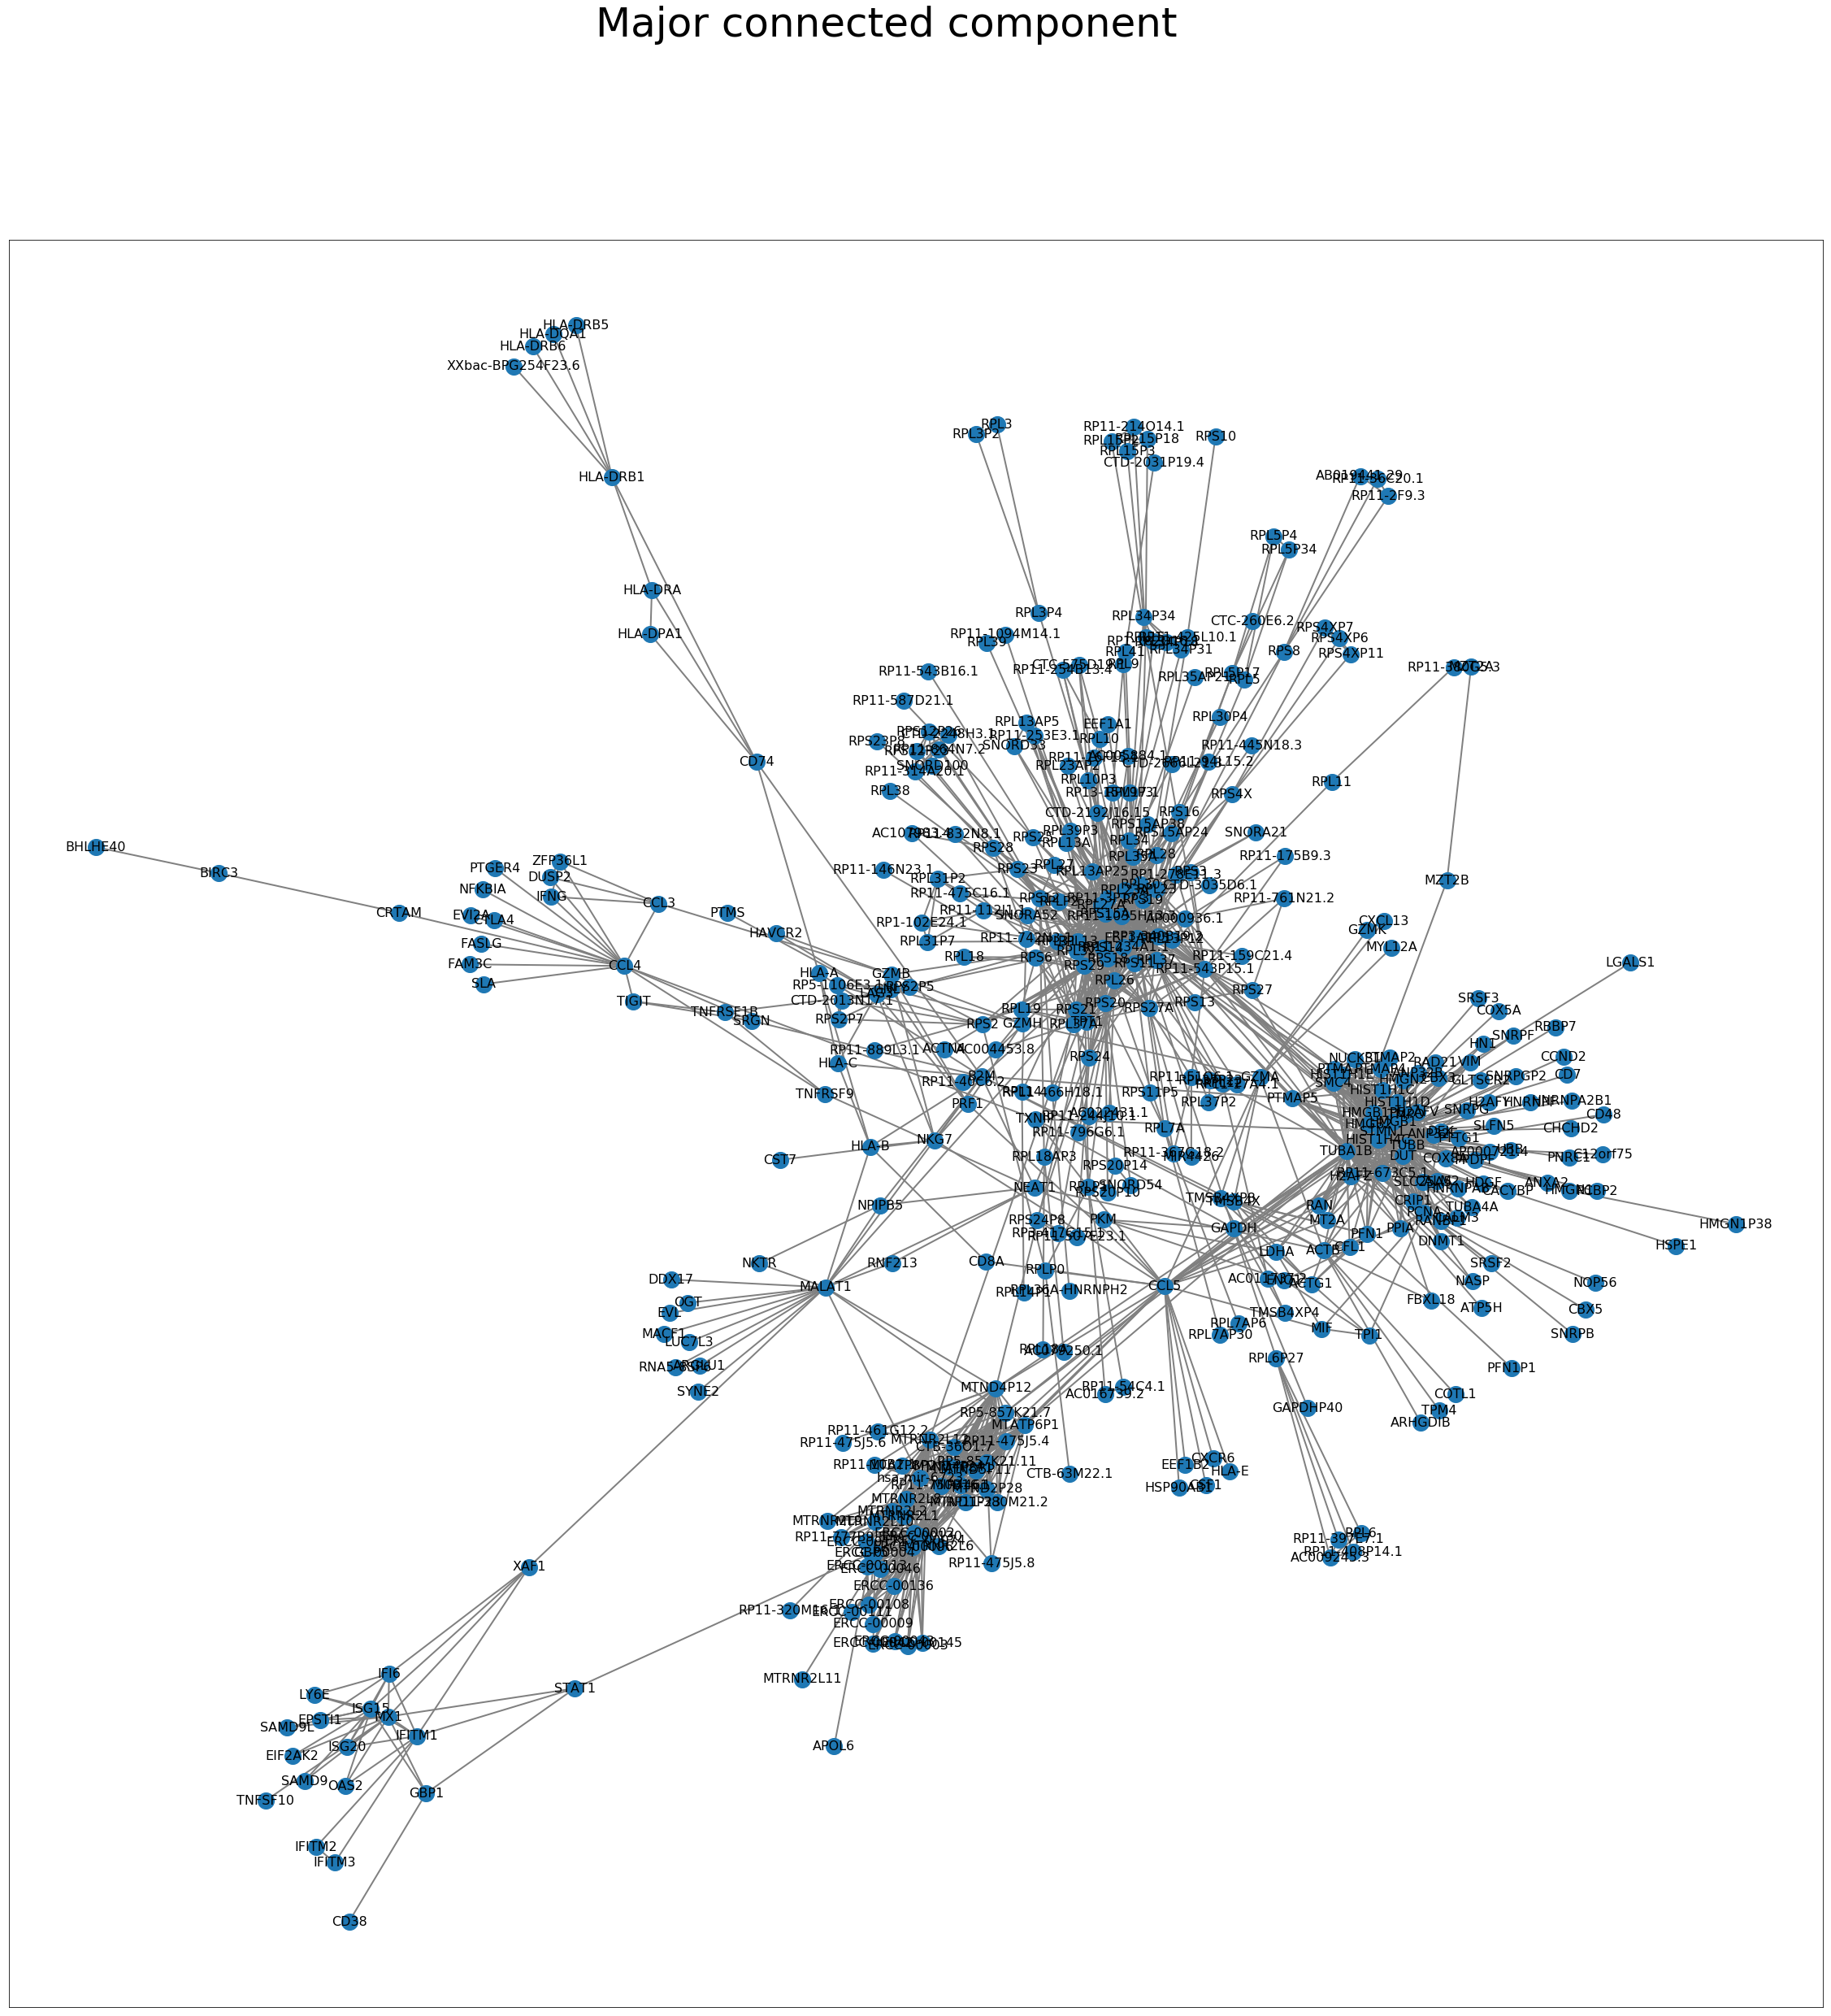

Co-expression with 1 GO covariates removed.
Number of nodes in full network: 481
Number of edges in full network: 1071
Number of nodes in major connected component: 220
Number of edges in major connected component: 774


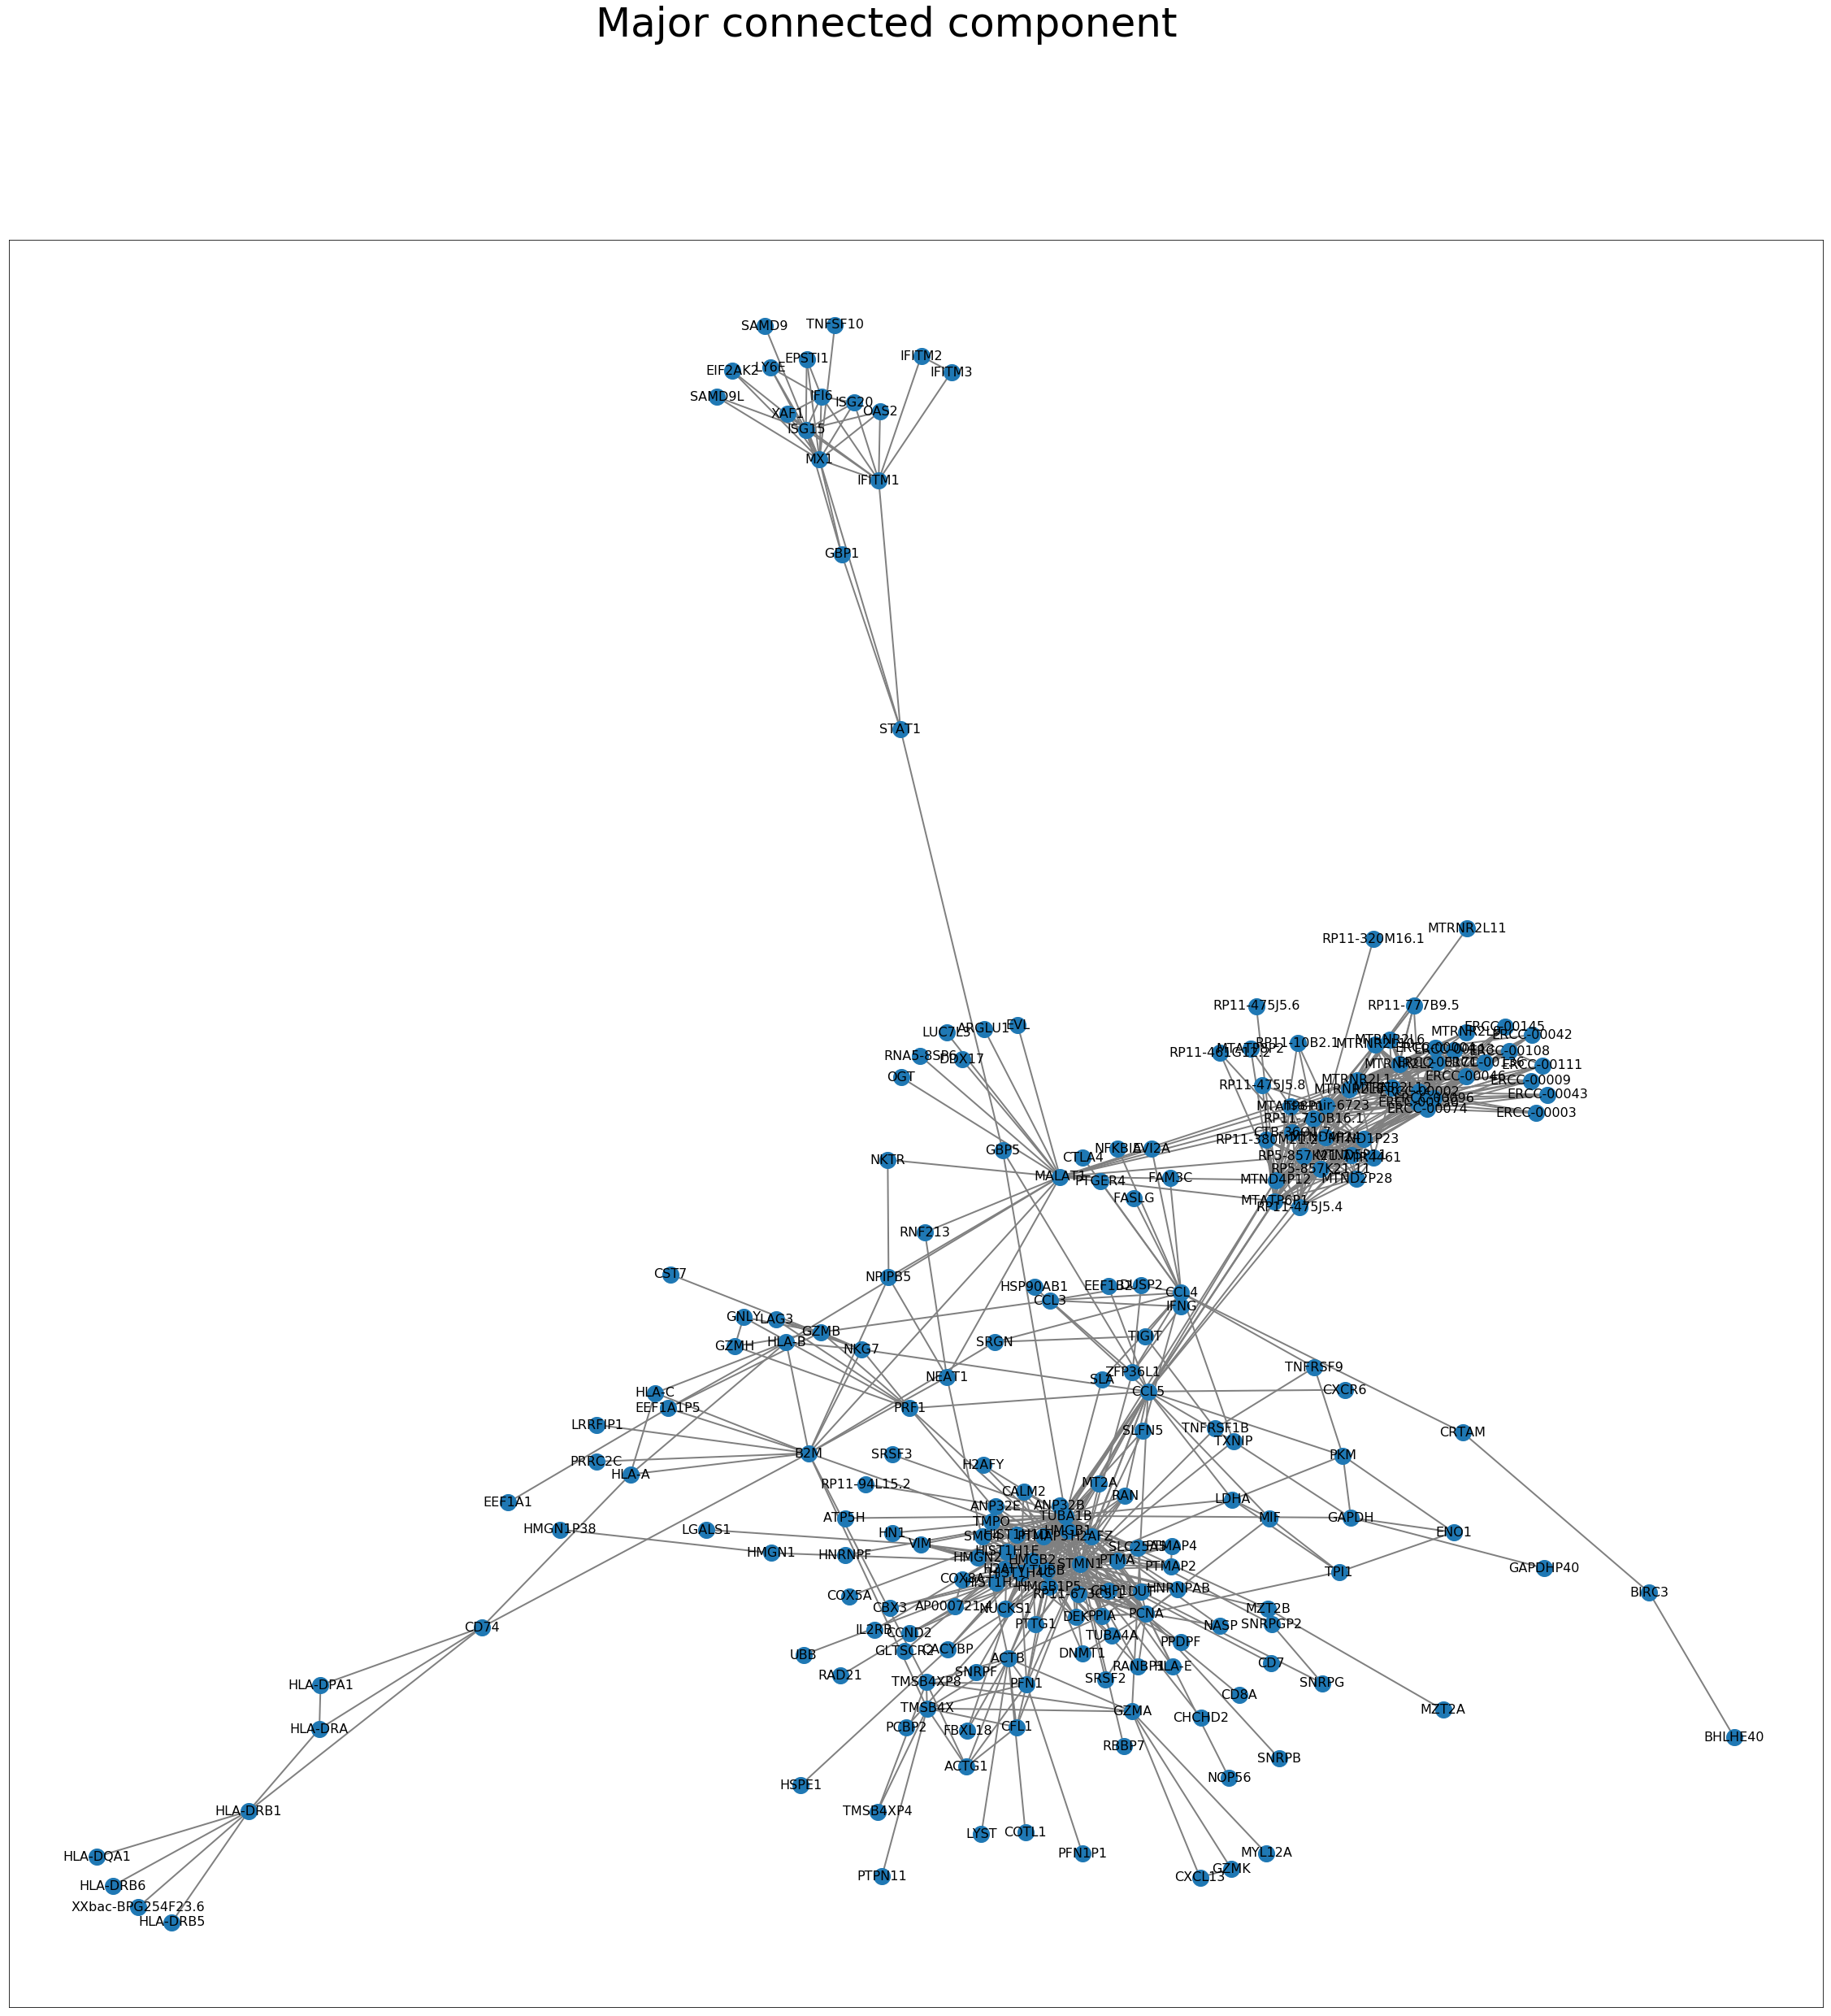

Co-expression with 2 GO covariates removed.
Number of nodes in full network: 476
Number of edges in full network: 954
Number of nodes in major connected component: 207
Number of edges in major connected component: 638


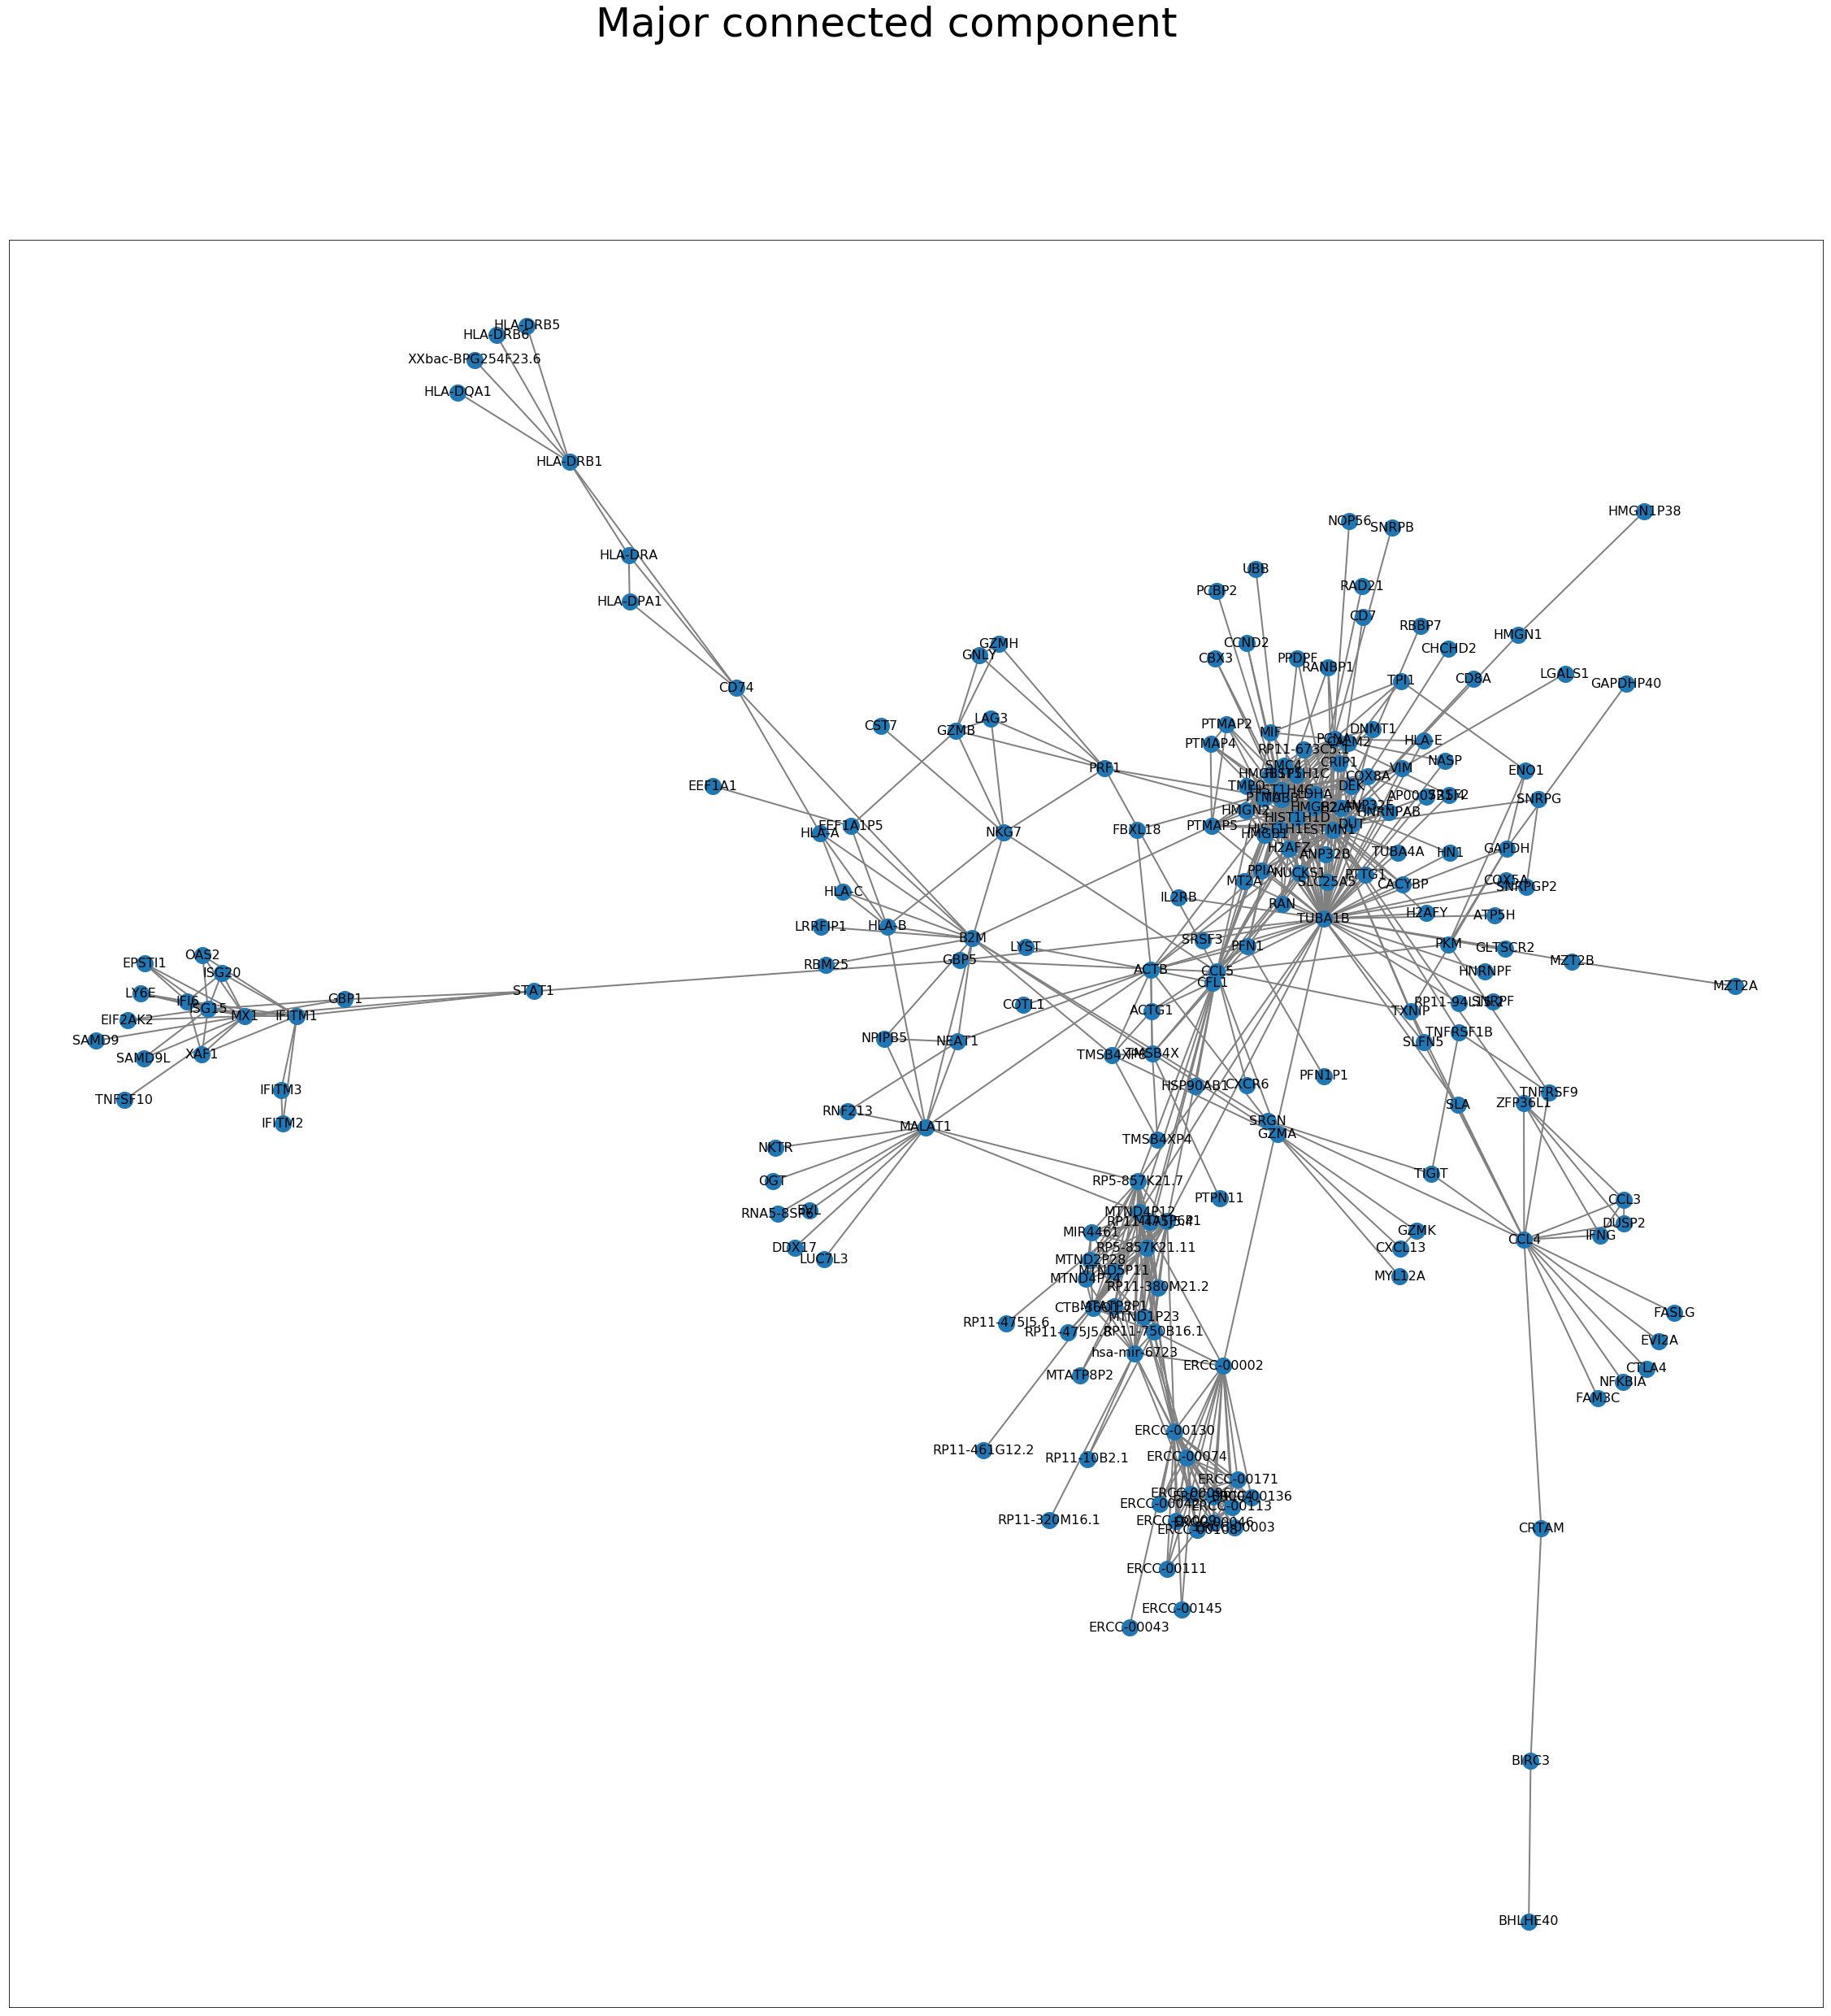

Co-expression with 3 GO covariates removed.
Number of nodes in full network: 476
Number of edges in full network: 948
Number of nodes in major connected component: 215
Number of edges in major connected component: 651


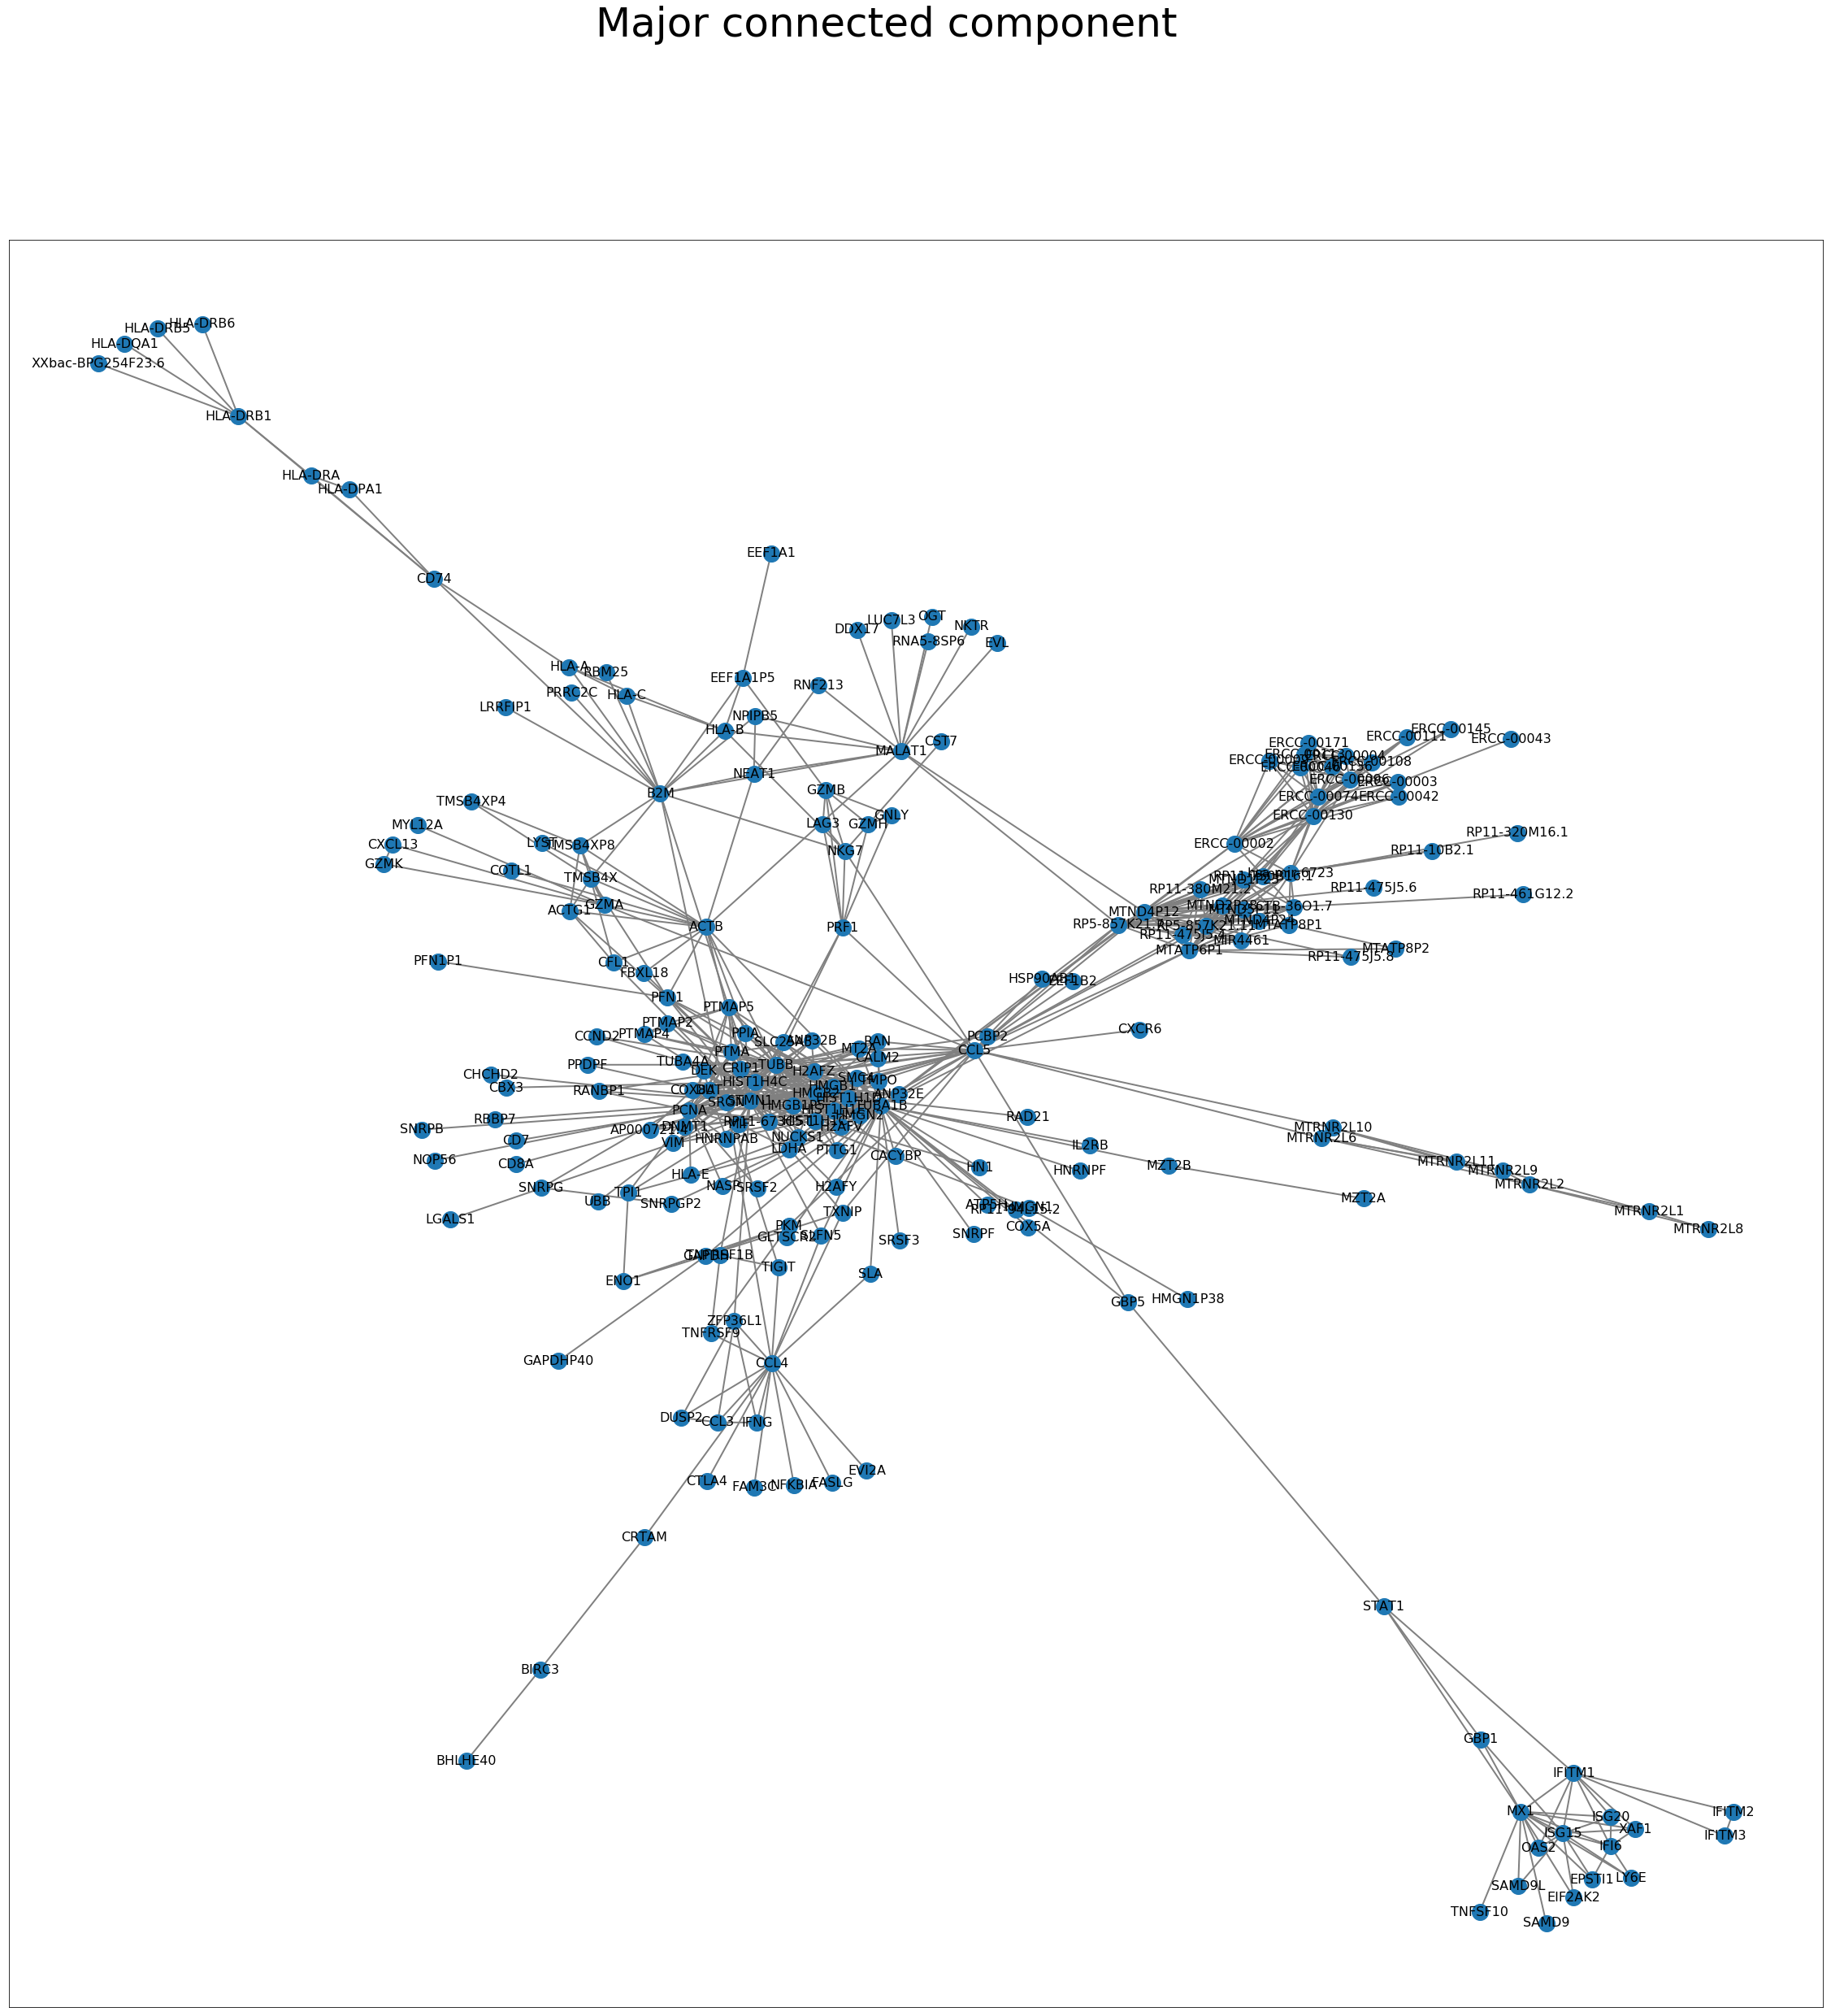

Co-expression with 4 GO covariates removed.
Number of nodes in full network: 459
Number of edges in full network: 864
Number of nodes in major connected component: 194
Number of edges in major connected component: 565


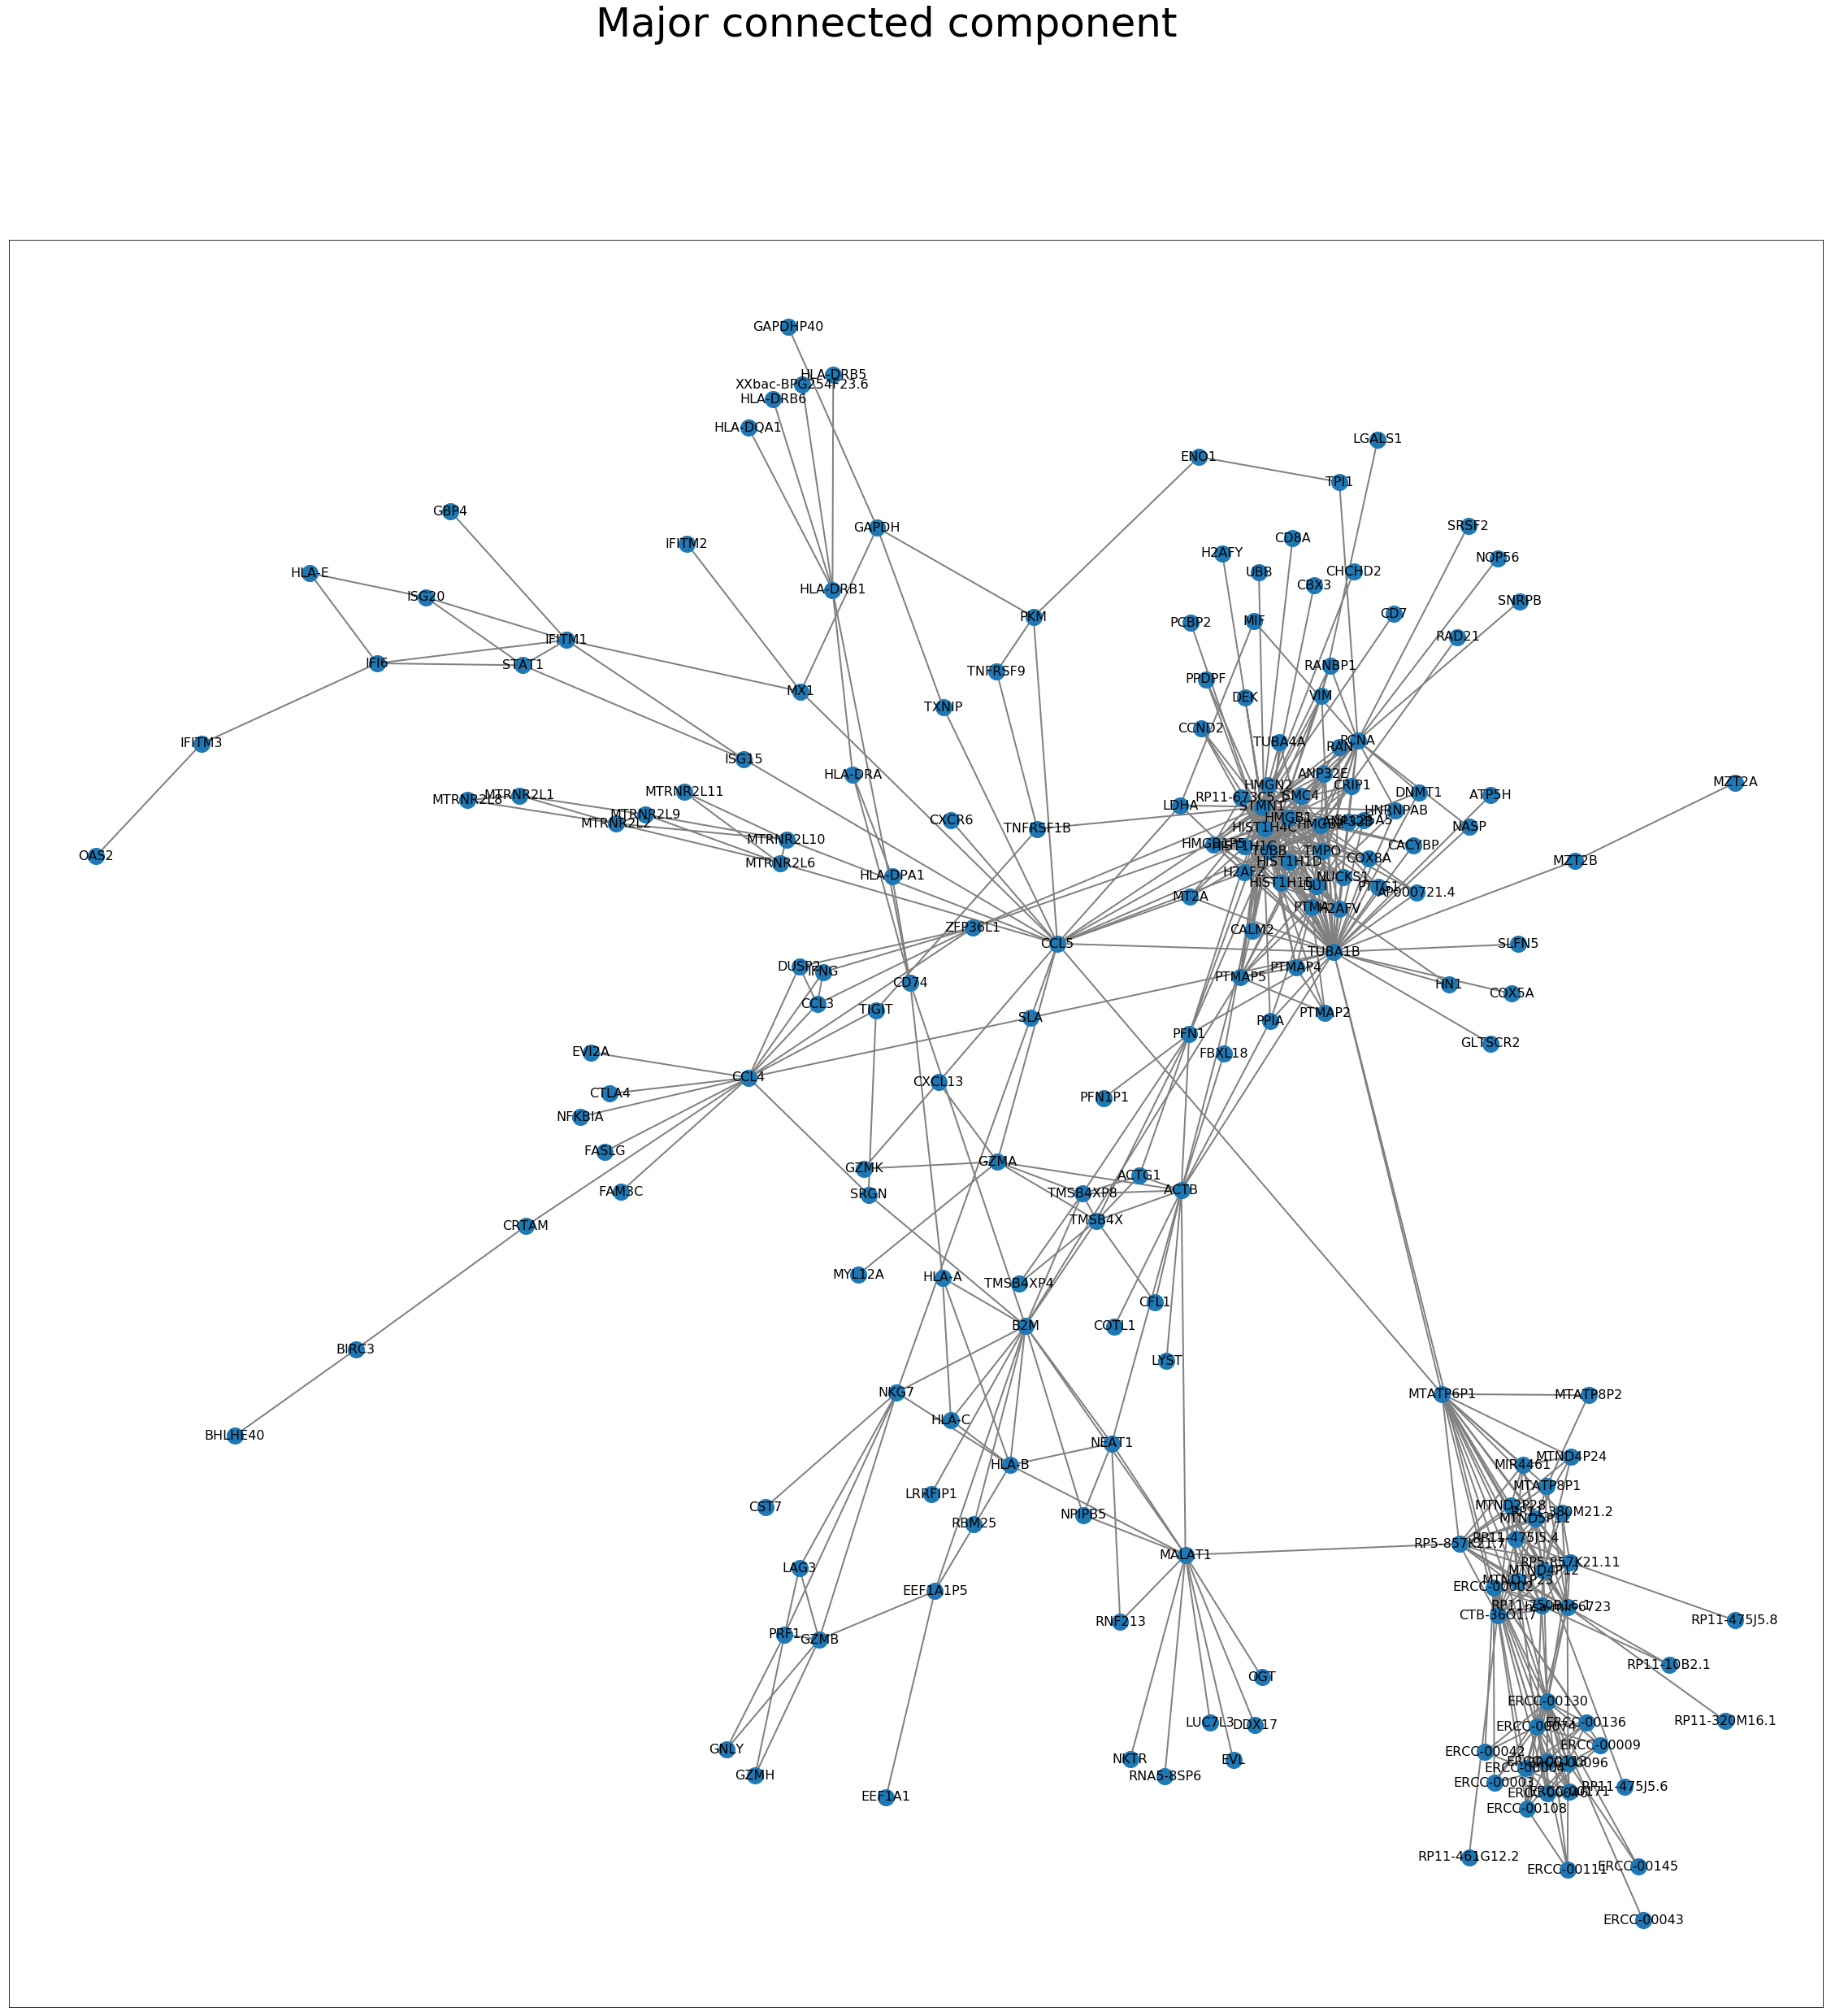

Co-expression with 5 GO covariates removed.
Number of nodes in full network: 463
Number of edges in full network: 882
Number of nodes in major connected component: 200
Number of edges in major connected component: 584


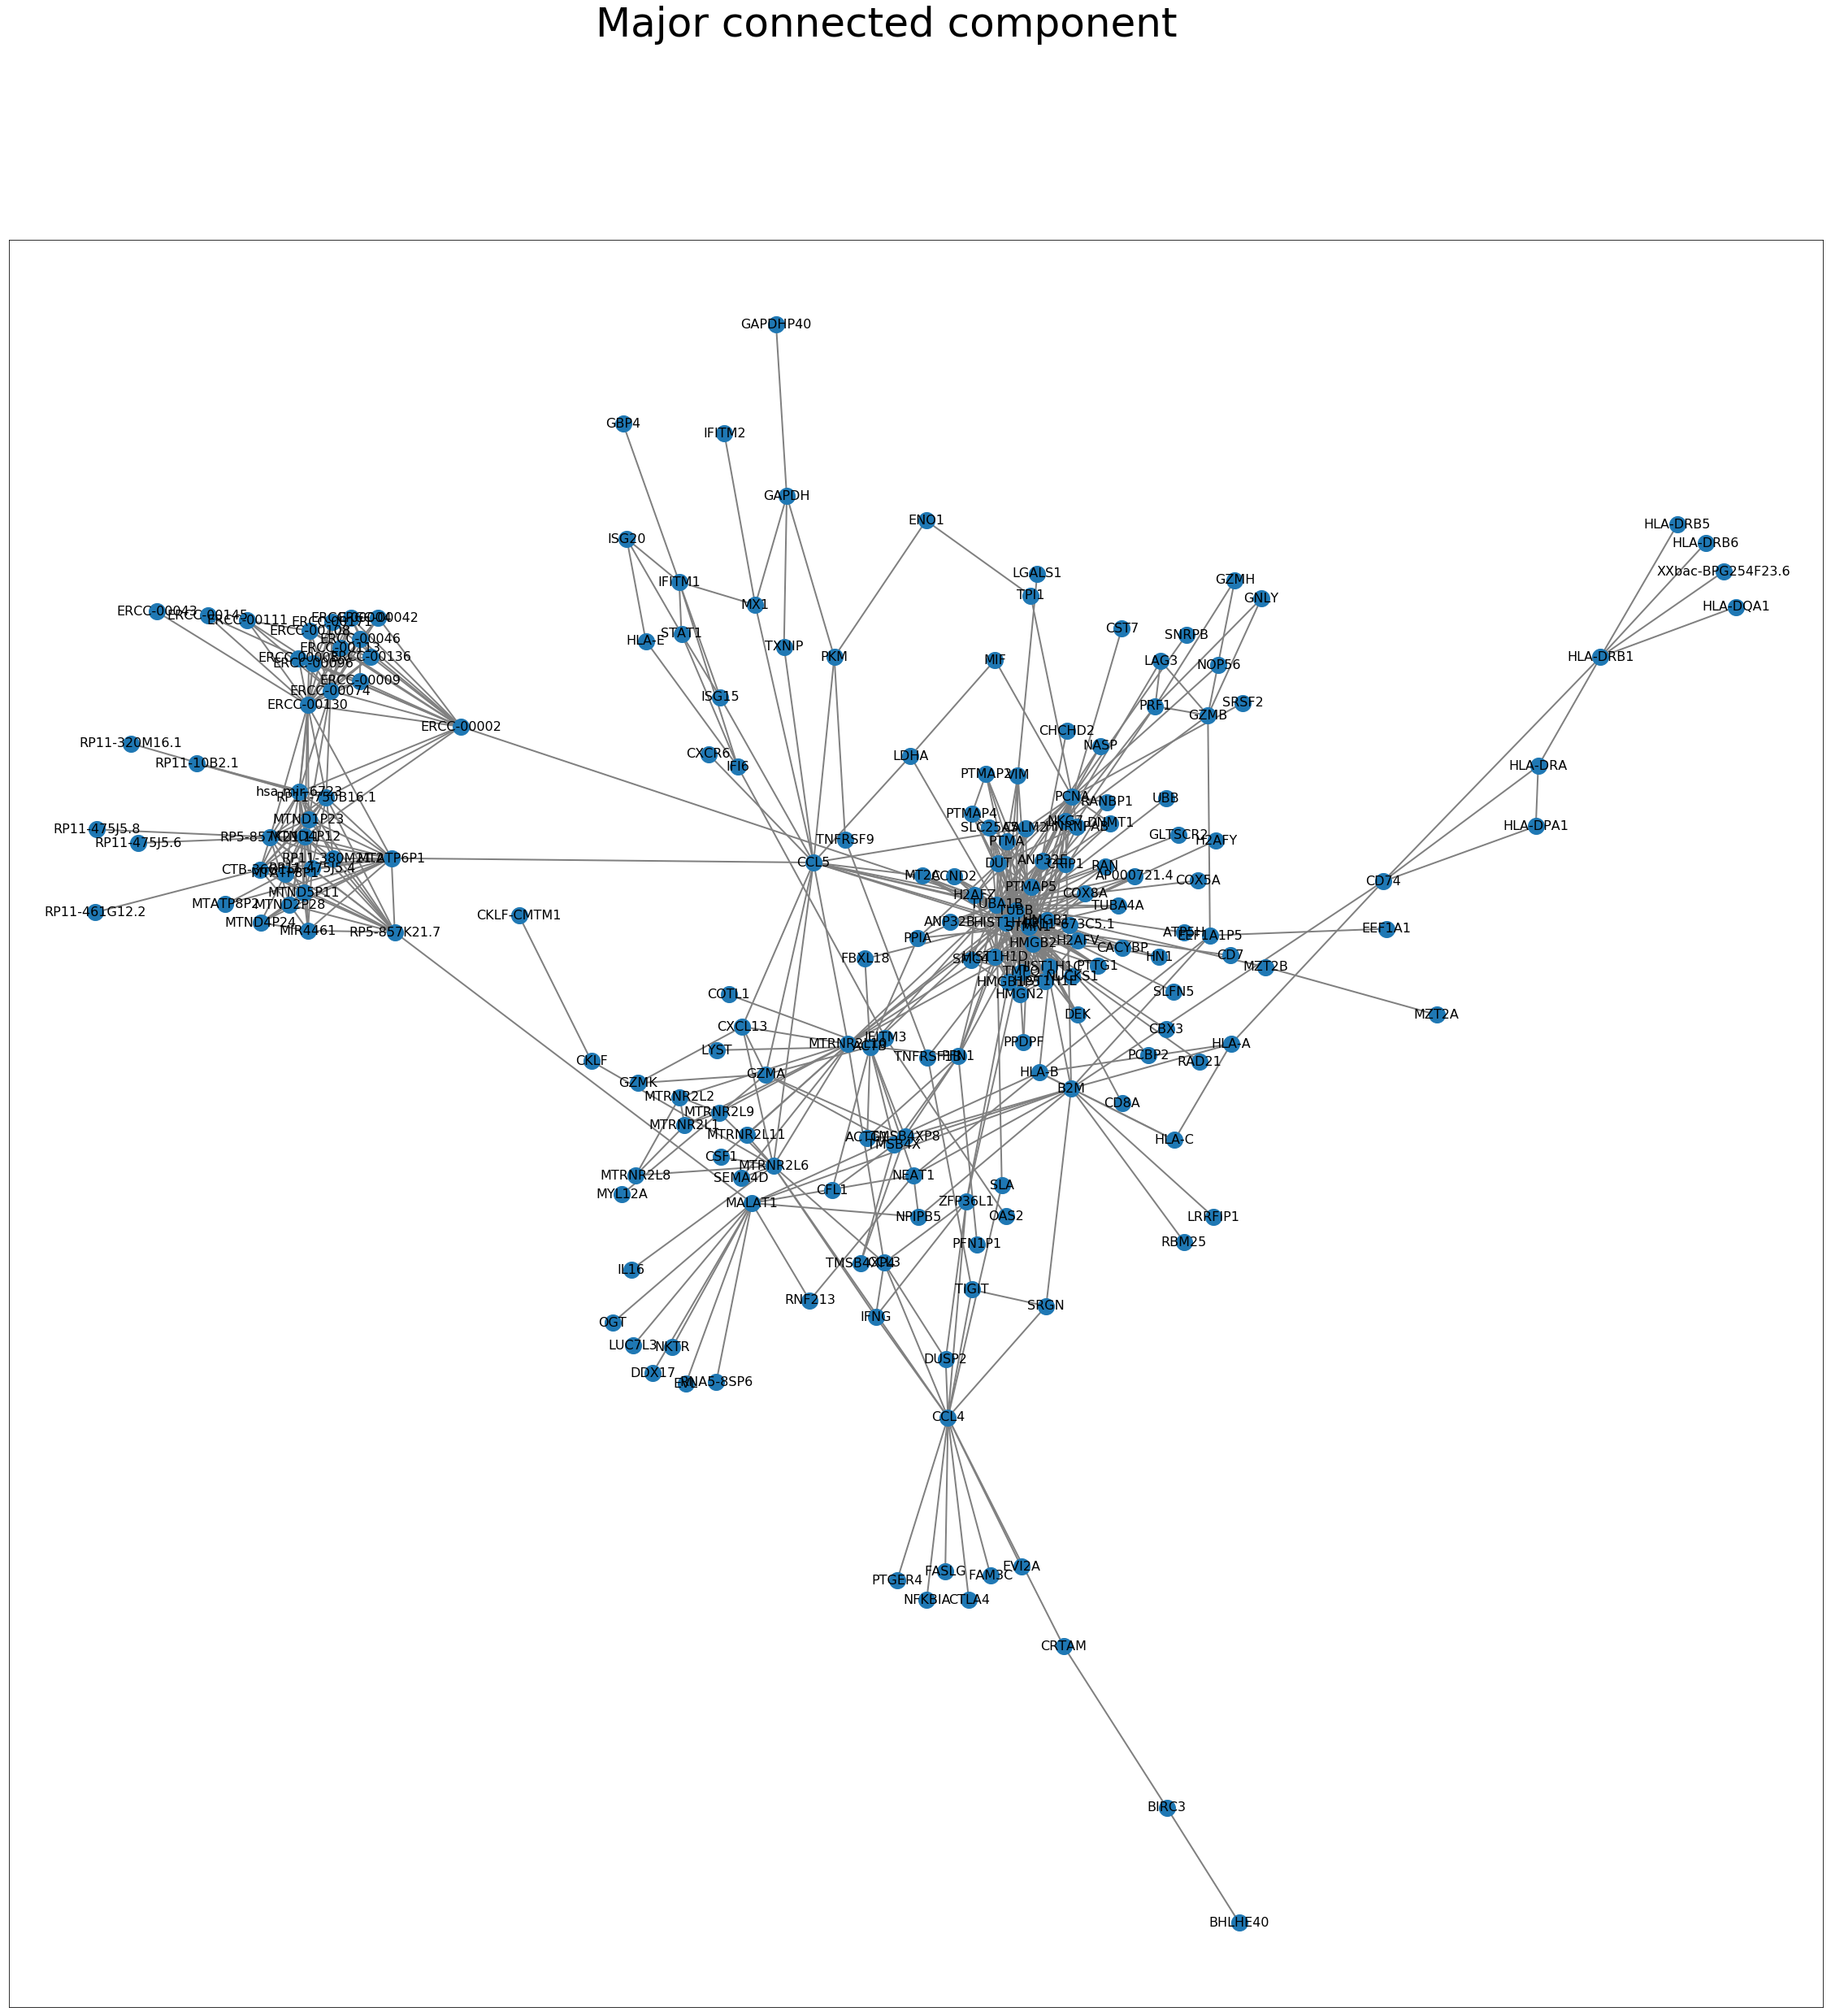

In [14]:
figscale=2
tdict=dict(zip(namet,range(len(namet))))
for xi in range(lvmax+1):
	print('Co-expression with {} GO covariates removed.'.format(xi))
	net=coex[xi][1]
	net|=net.T
	t1=net.any(axis=1)>0
	net=net[t1][:,t1]
	tnet=namet[t1]
	print('Number of nodes in full network: {}'.format(net.shape[0]))
	print('Number of edges in full network: {}'.format(net.sum()//2))
	#To major connected component
	t1=np.zeros_like(net)
	net2=net.copy()
	while (t1!=net2).any():
		t1=net2.copy()
		net2|=np.matmul(net2,net2)
	t1=net2.sum(axis=0)
	t1=t1==t1.max()
	net=net[t1][:,t1]
	tnet=tnet[t1]
	print('Number of nodes in major connected component: {}'.format(net.shape[0]))
	print('Number of edges in major connected component: {}'.format(net.sum()//2))
	#Draw here
	net2=pd.DataFrame(net,index=tnet,columns=tnet)
	net3=nx.to_networkx_graph(net2)
	f=plt.figure(figsize=(20*figscale,20*figscale))
	nx.draw_networkx(net3,node_size=200*figscale,font_size=8*figscale,width=1*figscale,edge_color=[0.5]*3);
	f.suptitle('Major connected component',fontsize=25*figscale);
	plt.show()
	#You can also output the network and draw it in Cytoscape